# 1.메타러너 연습

In [ ]:
!pip install xgboost causalml lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.3 MB/s eta 0:00:00


In [ ]:
from causalml.inference.meta import BaseTClassifier
from causalml.metrics import plot_gain, plot_qini
from causalml.metrics import auuc_score, qini_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("pm_train.csv", index_col=[0])
df.head()

df["trmt1"] = df.setting1.apply( lambda x: x<0)
df.trmt1.value_counts()

df["trmt2"] = df.setting2.apply( lambda x: x<0)
df.trmt2.value_counts()

df["trmt3"] = (df.trmt2 & df.trmt1)

df["target"] = df.ttf.apply(lambda x: x<10)
df.target.value_counts()
df.trmt3.value_counts()

,count
trmt3,
False,16115
True,4516


In [ ]:
trmt_ratio = df.query("trmt3==1 & target==1").shape[0] / df.query("trmt3==1").shape[0]
control_ratio = df.query("trmt3==0 & target==1").shape[0] / df.query("trmt3==0").shape[0]
print(f"Treatment Ratio: {trmt_ratio}")
print(f"Control Ratio: {control_ratio}")
print(f"T/C:{trmt_ratio-control_ratio}")

Treatment Ratio: 0.05447298494242692
Control Ratio: 0.046788706174371704
T/C:0.007684278768055219


In [ ]:
confounding_col = [ 's' + str(i)  for i in range(22) if i > 0]

- 결측치 제거

In [ ]:
df = df.replace(' ', np.nan).dropna()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20631 entries, 0 to 20630
Data columns (total 31 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   setting1  20631 non-null  float64
 3   setting2  20631 non-null  float64
 4   setting3  20631 non-null  float64
 5   s1        20631 non-null  float64
 6   s2        20631 non-null  float64
 7   s3        20631 non-null  float64
 8   s4        20631 non-null  float64
 9   s5        20631 non-null  float64
 10  s6        20631 non-null  float64
 11  s7        20631 non-null  float64
 12  s8        20631 non-null  float64
 13  s9        20631 non-null  float64
 14  s10       20631 non-null  float64
 15  s11       20631 non-null  float64
 16  s12       20631 non-null  float64
 17  s13       20631 non-null  float64
 18  s14       20631 non-null  float64
 19  s15       20631 non-null  float64
 20  s16       20631 non-null  float64

In [ ]:
for i in ["target", "trmt1","trmt2", "trmt3"]:
    df[i] = df[i].astype(int)

In [ ]:
y = "target"
T = "trmt3"
X = confounding_col

train, test = train_test_split(df, test_size=0.2, random_state=1, stratify=df[T])

In [ ]:
t_learner_xgb = BaseTClassifier(learner=XGBClassifier(random_state=24,n_estimators=50,verbosity=0),control_name=0, ate_alpha=0.05)

t_learner_xgb.fit(X=train[X], treatment=train[T], y=train[y])
ate_t_xgb = t_learner_xgb.estimate_ate(X=test[X], treatment=test[T], y=test[y])
ite_t_xgb = t_learner_xgb.predict(X=test[X], treatment=test[T])

- ATE (Average Treatment Effect)
 - ATE=E[Y∣T=1]−E[Y∣T=0]
 - 처리군(treatment)과 통제군(control)의 평균 결과 차이.처리효과의 평균값
 - ATE_lb (하한): ATE의 신뢰구간 하한값 (lower bound), 예: 95% 신뢰구간이라면 “ATE가 이 값보다 클 확률이 95%”라는 의미.
 - ATE_ub (상한): ATE의 신뢰구간 상한값 (upper bound). 예: 95% 신뢰구간이라면 “ATE가 이 값보다 작을 확률이 95%”라는 의미.



In [ ]:
ate_t_xgb

(array([-0.00144333]), array([-0.00520102]), array([0.00231435]))

In [ ]:
result = pd.DataFrame(ite_t_xgb, columns=['treatment'])
best_treatment = np.where((result < 0).all(axis=1), 'c', result.idxmax(axis=1))

actual_is_best = np.where(test[T].replace([0,1],['c','treatment']) == best_treatment, 1, 0)
actual_is_control = np.where(test[T].replace([0,1],['c','treatment']) == 'c', 1, 0)
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]

auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             target = test.loc[synthetic, 'target'].values.astype(int),
                             uplift_tree = synth.max(axis=1)))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

importance_dict = t_learner_xgb.get_importance(
    X=test[X],
    tau=ite_t_xgb,
    method='auto',
    features=test[X].columns,
    test_size=0.25,
    random_state=1)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

In [ ]:
importance_series = importance_dict[np.int64(1)]
importance_df = importance_series.reset_index()
importance_df.columns = ['feature_name', 'feature_importance']
importance_df = importance_df.sort_values(by='feature_importance', ascending=False)
print(importance_df)

   feature_name  feature_importance
0            s4            0.120753
1           s11            0.115986
2            s3            0.107070
3           s14            0.091140
4           s12            0.086566
5            s2            0.082475
6           s15            0.076255
7            s7            0.068971
8            s8            0.058611
9           s21            0.051289
10          s20            0.048980
11           s9            0.039121
12          s13            0.035614
13          s17            0.017168
14           s1            0.000000
15           s5            0.000000
16           s6            0.000000
17          s10            0.000000
18          s16            0.000000
19          s19            0.000000
20          s18            0.000000


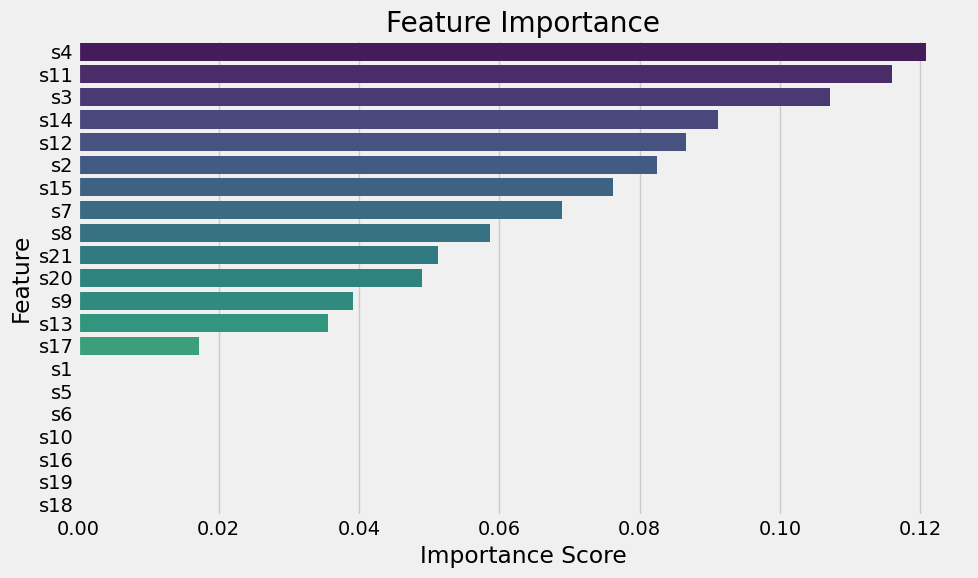

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(
    x='feature_importance',
    y='feature_name',
    data=importance_df,
    palette='viridis'
)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


<Axes: >

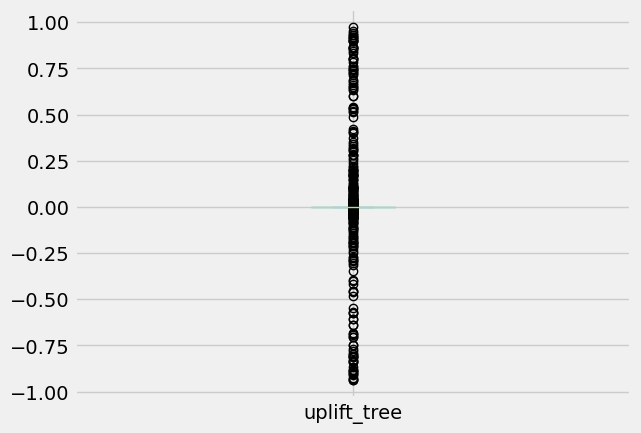

In [ ]:
auuc_metrics.uplift_tree.plot(kind='box')

- Propensity Scoring Matching
<매칭 (Matching)>
- 목적: 처리군과 비처리군 간 유사한 관측치를 매칭하여 인과 효과를 추정.
- 실험 데이터에는 의미가 없으며 관찰 데이터에서만 의미 있음.
>조건 및 특징
1. 관련 변수(교란 변수 포함)가 동일해야 이상적
2. 유사한 관측치를 쌍으로 연결할 수 있는 유연성 존재
3. 처리와 결과 사이 관계에 교란이 없어야 함
4. 모든 교란 요인이 관찰 가능하며 매칭 피처셋에 포함되어야 함
5. 콜라이더를 제어하고 DAG(유향 비순환 그래프)를 활용해 편향 방지

<성향 점수 (Propensity Score)>
- 특정 단위가 특성에 따라 처리군에 배정될 확률.
- 이분법적 처리에서는 이상적 성향점수 = 0.5
- 단순 평균이나 무작위 선택은 매칭 역효과
- 성향 점수 가중치 (Propensity Score Weighting): 교란 제거를 위해 하위 집단 구성 및 가중치 부여 → 관찰되지 않은 교란 존재 시 효과 없음.
- IPW (Inverse Probability Weighting): 의사 모집단(pseudo population) 생성하여 과소 대표된 그룹에는 높은 가중치, 과대표된 그룹에는 낮은 가중치 → 교란 제어

In [ ]:
from sklearn.linear_model import LogisticRegression

# Propensity Score
ps_model = LogisticRegression(max_iter=2000, penalty=None, C=2,class_weight='balanced', random_state=24)
ps_model.fit(test[X], test[T])
propensity_score = ps_model.predict_proba(test[X])[:, 1]  # trmt=1일 확률

test['ITE'] = ite_t_xgb  # 위에서 나온 ITE 추정치
test['propensity_score'] = propensity_score

In [ ]:
label_map = {
    (0, 0): 'trmt bad_target bad',
    (0, 1): 'trmt bad_target good',
    (1, 0): 'trmt good_target bad',
    (1, 1): 'trmt good_target good'
}
test['group_label'] = test[[T, y]].apply(lambda row: label_map[tuple(row)], axis=1)
test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s20,s21,ttf,trmt1,trmt2,trmt3,target,ITE,propensity_score,group_label
11364,57,110,-0.0012,-0.0004,100.0,518.67,643.03,1601.55,1413.33,14.62,...,38.61,23.3253,27,1,1,1,0,0.000131,0.431172,trmt good_target bad
4240,21,73,-0.0031,-0.0000,100.0,518.67,642.74,1589.44,1407.22,14.62,...,38.85,23.3874,122,1,0,0,0,0.000050,0.481498,trmt bad_target bad
2235,11,100,0.0018,0.0000,100.0,518.67,642.32,1587.87,1402.81,14.62,...,38.81,23.3760,140,0,0,0,0,0.000046,0.469302,trmt bad_target bad
14332,71,203,-0.0046,-0.0003,100.0,518.67,643.66,1596.68,1432.54,14.62,...,38.63,23.0642,5,1,1,1,1,-0.017452,0.534846,trmt good_target good
3443,17,139,-0.0000,0.0003,100.0,518.67,642.54,1594.99,1394.70,14.62,...,38.89,23.3232,137,0,0,0,0,0.000033,0.502075,trmt bad_target bad


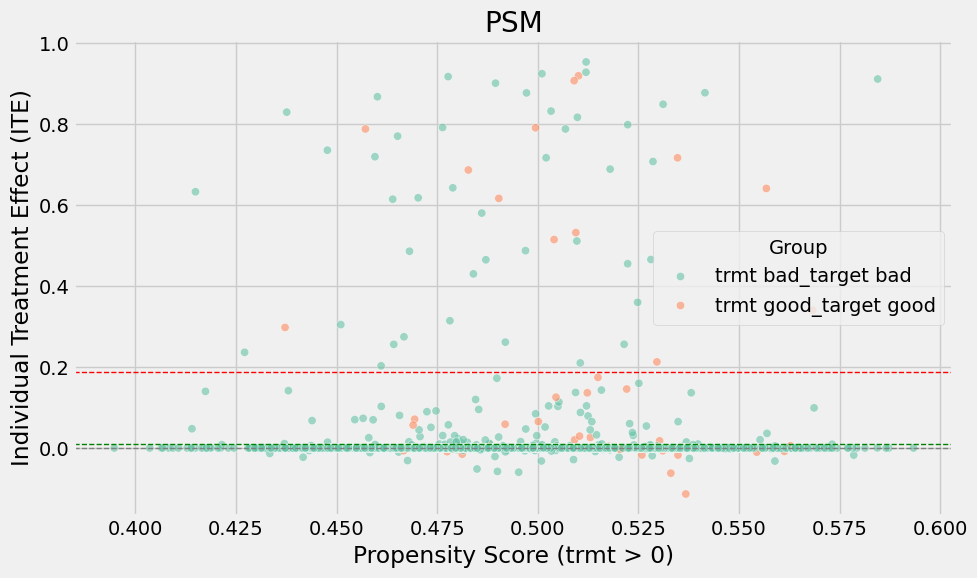

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=test.query("group_label=='trmt bad_target bad' | group_label=='trmt good_target good'"),
                x='propensity_score',
                y='ITE',
                hue='group_label',
                palette='Set2',
                alpha=0.6)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(test.query("group_label=='trmt bad_target bad'")['ITE'].mean(), color='green', linestyle='--', linewidth=1)
plt.axhline(test.query("group_label=='trmt good_target good'")['ITE'].mean(), color='red', linestyle='--', linewidth=1)
plt.xlabel('Propensity Score (trmt > 0)')
plt.ylabel('Individual Treatment Effect (ITE)')
plt.title('PSM')
plt.legend(title='Group')
plt.tight_layout()
plt.show()

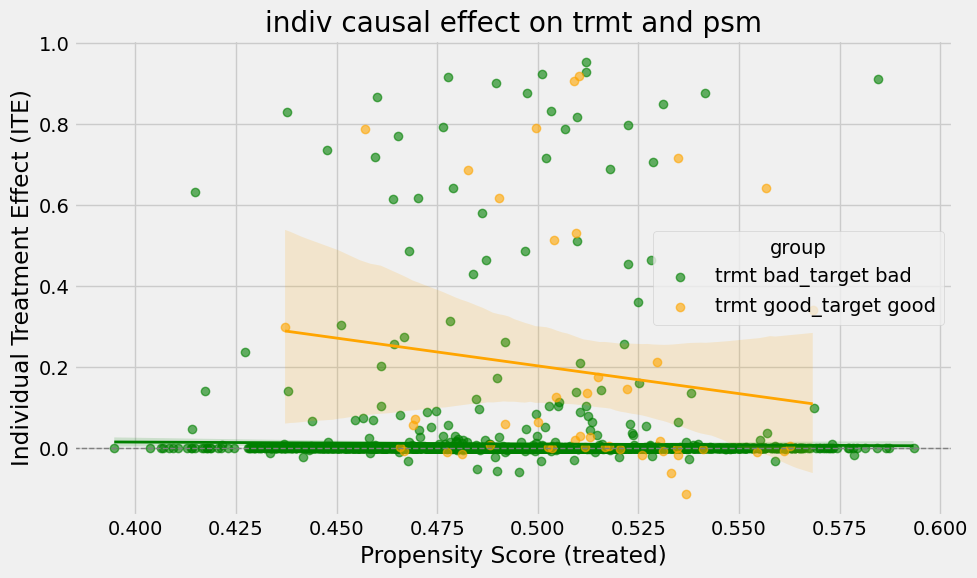

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(data=test.query("group_label=='trmt bad_target bad'"),
            x='propensity_score',
            y='ITE',
            scatter=True,
            color='green',
            label='trmt bad_target bad',
            scatter_kws={'alpha': 0.6},
           line_kws={'linewidth': 2})

sns.regplot(data=test.query("group_label=='trmt good_target good'"),
            x='propensity_score',
            y='ITE',
            scatter=True,
            color='orange',
            label='trmt good_target good',
            scatter_kws={'alpha': 0.6},
           line_kws={'linewidth': 2})

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Propensity Score (treated)')
plt.ylabel('Individual Treatment Effect (ITE)')
plt.title('Individual Causal Effect on trmt and psm')
plt.legend(title='group')

plt.tight_layout()
plt.show()

### trmt에 대한 target의 cate 비교
- Conditional Average Treatment Effect
- 특정 집단(혹은 조건)에 대해 평균적인 처치 효과를 추정한 값

In [ ]:
# CATE = trmt에서의 target 비율 − trmt 아닌 경우에서의 target 비율

In [ ]:
ex_data = test.copy()

In [ ]:
# 현재 setting1, target bad(A집단), trmt, target good(B집단)보다 개입에 대한 target 개선 효과가 약 28% 더 높음.

ex_data['trmt1'] = ex_data['trmt1'].replace([0,1],['Off','On'])
ex_data['target'] = ex_data['target'].replace([0,1],['bad','good'])

ex_data.pivot_table(index='trmt1', columns='target', values='ITE', aggfunc='mean')

target,bad,good
trmt1,,
Off,0.020019,-0.147660
On,-0.025391,0.143542


In [ ]:
## 통계 검정

# setting1, target good
ex_sufficient_good = ex_data[(ex_data['trmt1'] == 'On') & (ex_data['target'] == 'good')]
# trmt off, target bad
ex_insufficient_bad = ex_data[(ex_data['trmt1'] == 'Off') & (ex_data['target'] == 'bad')]

# 업리프트 차이 통계 검정 (예: t-test)
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(
    ex_sufficient_good['ITE'],
    ex_insufficient_bad['ITE'],
    equal_var=False
)
print(f"Uplift 차이 t-test: t-statistic={t_stat:.4f}, p-value={p_value:.4f}")

Uplift 차이 t-test: t-statistic=9.7863, p-value=0.0000


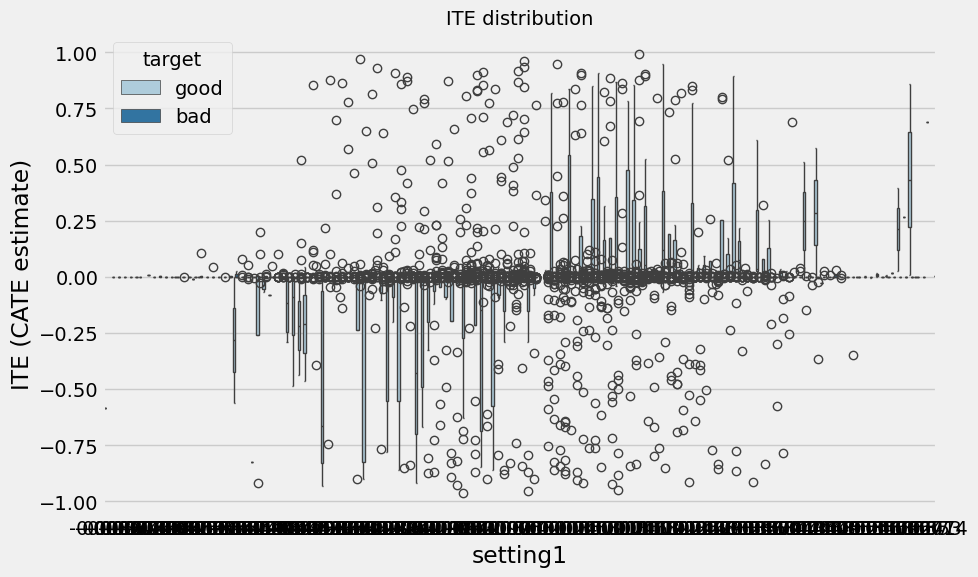

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_df = ex_data.copy()

# boxplot 그리기
plt.figure(figsize=(10,6))
sns.boxplot(data=plot_df, x='setting1', y='ITE', hue='target')

# 제목 및 축 라벨
plt.title("ITE distribution", fontsize=14)
plt.ylabel("ITE (CATE estimate)")
plt.xlabel("trmt")
plt.legend(title="target")

plt.tight_layout()
plt.show()


In [ ]:
ex_data.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s19,s20,s21,ttf,trmt1,trmt2,target,ITE,propensity_score,group_label
1790,9,78,-0.0005,-0.0001,100.0,518.67,641.81,1586.47,1406.30,14.62,...,100.0,39.09,23.4532,123,Off,0,bad,0.000005,0.487369,setting1 bad_target bad
1819,9,107,-0.0014,0.0002,100.0,518.67,641.90,1582.40,1405.78,14.62,...,100.0,38.98,23.3048,94,Off,1,bad,-0.000007,0.485183,setting1 bad_target bad
10386,53,52,0.0031,-0.0002,100.0,518.67,642.41,1592.82,1399.70,14.62,...,100.0,38.93,23.2233,143,On,0,bad,0.000016,0.493655,setting1 good_target bad
4412,22,50,-0.0040,-0.0002,100.0,518.67,642.61,1590.58,1409.53,14.62,...,100.0,38.64,23.3000,152,Off,0,bad,0.000982,0.480903,setting1 bad_target bad
18997,93,142,0.0029,0.0004,100.0,518.67,643.26,1597.54,1421.15,14.62,...,100.0,38.45,23.1465,13,On,1,good,0.256625,0.524790,setting1 good_target good


In [ ]:


a = ex_data.query("(trmt1=='On' & target=='good') | (trmt1=='Off' & target=='good')")['ITE'].mean() # Sure things
b = ex_data.query("(trmt1=='On' & target=='bad') | (trmt1=='Off' & target=='bad')")['ITE'].mean() # Lost Causes
c = ex_data.query("(trmt1=='On' & target=='good') | (trmt1=='Off' & target=='bad')")['ITE'].mean() # Persuadables
d = ex_data.query("(trmt1=='On' & target=='bad') | (trmt1=='Off' & target=='good')")['ITE'].mean() # Do-not-Disturbs

print(f'Sure things : {a}')
print(f'Lost Causes : {b}')
print(f'Persuadables : {c}')
print(f'Do-not-Disturbs : {d}')

Sure things : 0.006003358238553638
Lost Causes : -0.002052297956938374
Persuadables : 0.03881462423780714
Do-not-Disturbs : -0.04314364980405754


# 2. 교란변수별 CATE

In [ ]:
confounding_col

['s1',
 's2',
 's3',
 's4',
 's5',
 's6',
 's7',
 's8',
 's9',
 's10',
 's11',
 's12',
 's13',
 's14',
 's15',
 's16',
 's17',
 's18',
 's19',
 's20',
 's21']

Setting1, target good:518.67
Setting1 Off, target bad:518.67
p-value: nan



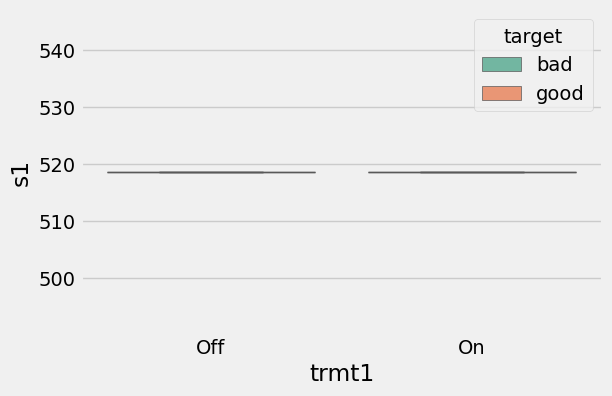

Setting1, target good:643.3975514403292
Setting1 Off, target bad:642.5622784342689
p-value: 1.191328036639622e-208



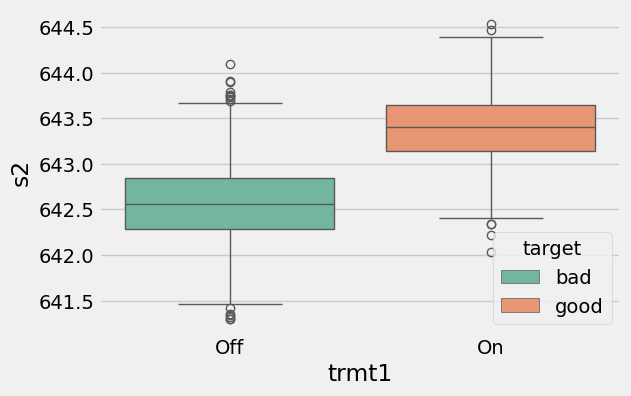

Setting1, target good:1598.6061111111112
Setting1 Off, target bad:1589.1344571639588
p-value: 4.796048981322085e-186



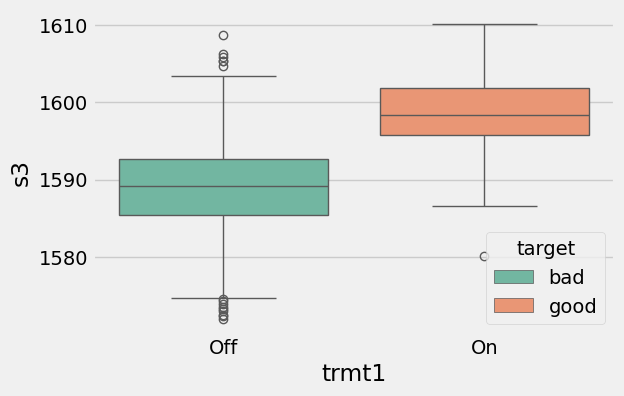

Setting1, target good:1422.7572016460906
Setting1 Off, target bad:1406.4608677991137
p-value: 1.6150555170116392e-275



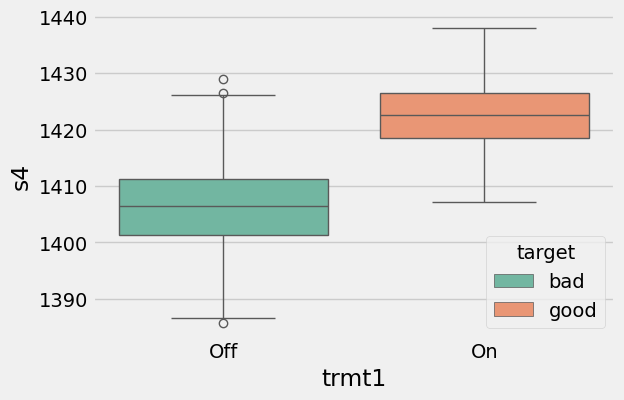

Setting1, target good:14.620000000000001
Setting1 Off, target bad:14.620000000000003
p-value: 1.4722506546873423e-57



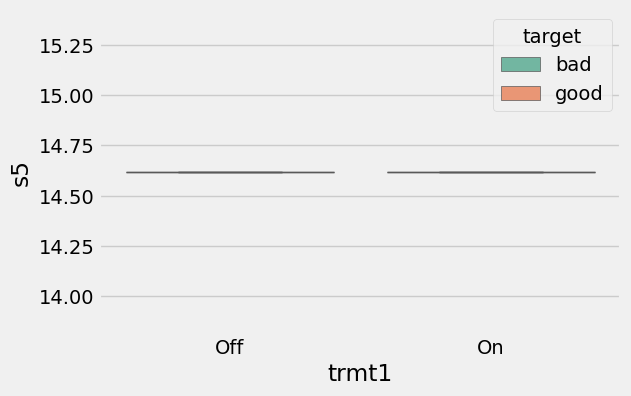

Setting1, target good:21.610000000000007
Setting1 Off, target bad:21.60975627769572
p-value: 3.0346833867346904e-16



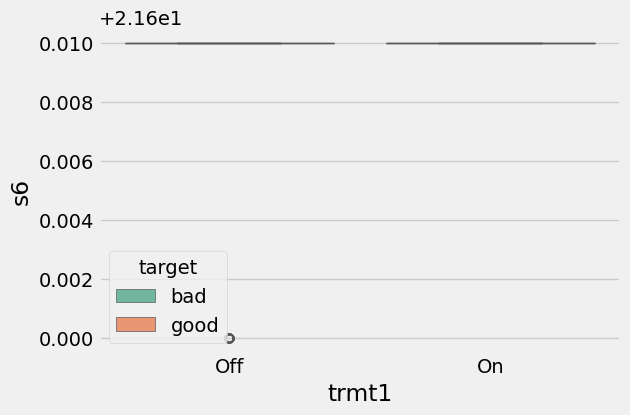

Setting1, target good:552.0404115226337
Setting1 Off, target bad:553.5883862629247
p-value: 2.924844850966986e-252



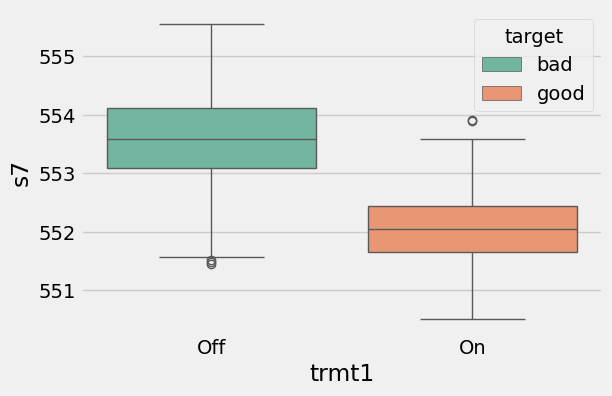

Setting1, target good:2388.1882510288065
Setting1 Off, target bad:2388.0819756277697
p-value: 4.616593165997297e-152



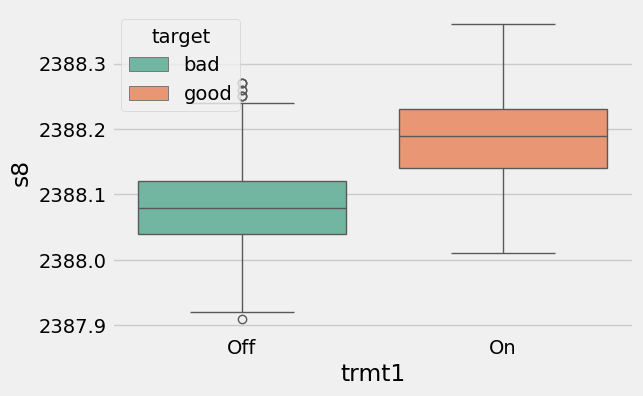

Setting1, target good:9087.94380658436
Setting1 Off, target bad:9061.475306499262
p-value: 9.924482338581854e-38



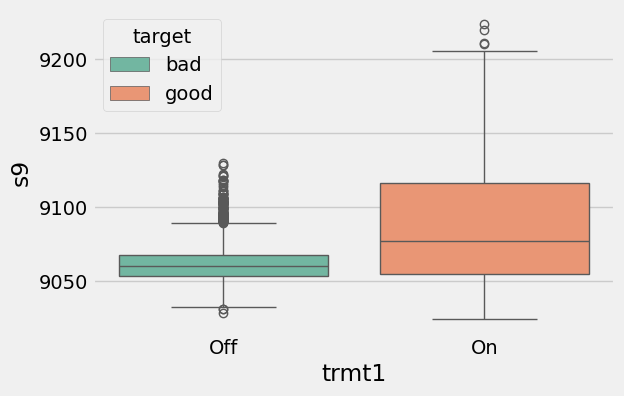

Setting1, target good:1.3000000000000003
Setting1 Off, target bad:1.3000000000000003
p-value: 1.0



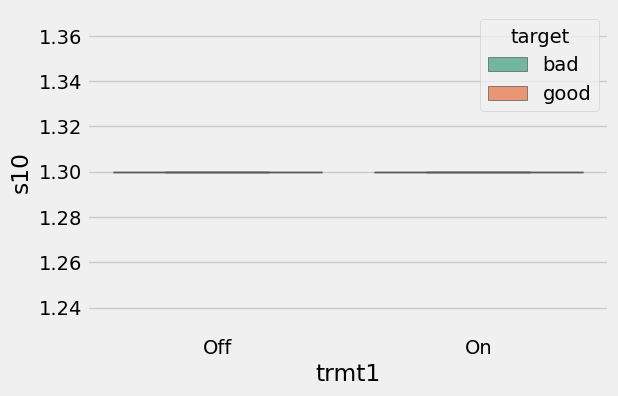

Setting1, target good:47.97189300411522
Setting1 Off, target bad:47.47255169867061
p-value: 4.009855988358298e-289



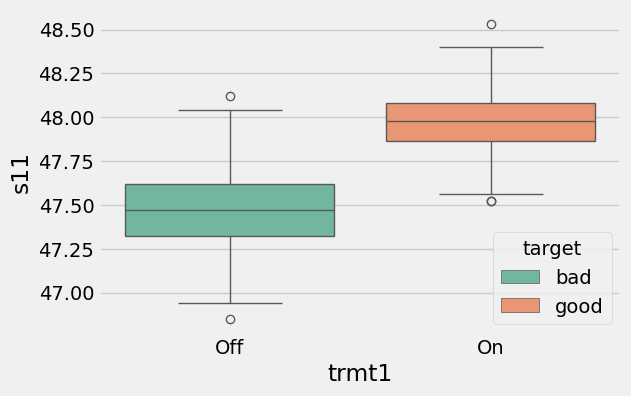

Setting1, target good:520.2710288065844
Setting1 Off, target bad:521.6053360413589
p-value: 7.678023782700627e-252



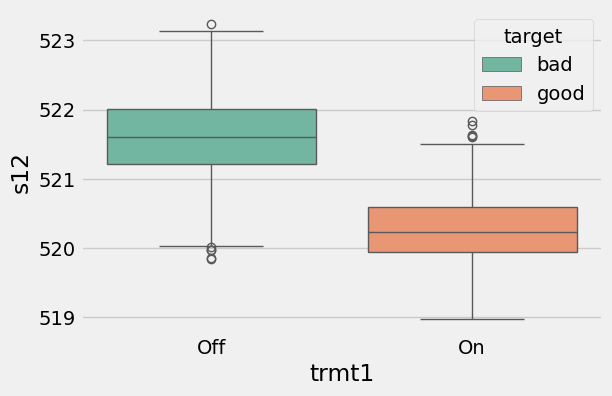

Setting1, target good:2388.186728395062
Setting1 Off, target bad:2388.0805686853764
p-value: 7.812854612732211e-150



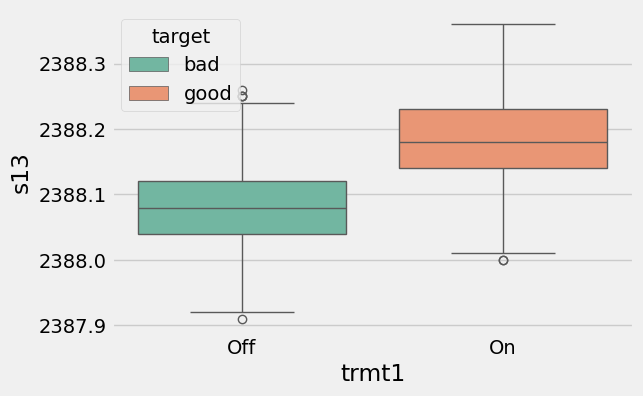

Setting1, target good:8159.757037037037
Setting1 Off, target bad:8141.152950516987
p-value: 2.8355820268898665e-25



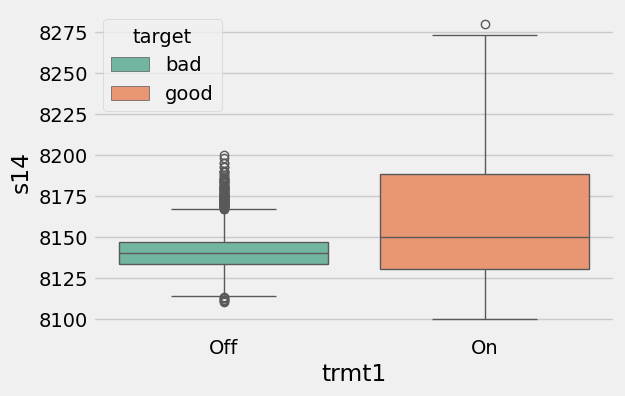

Setting1, target good:8.497697119341565
Setting1 Off, target bad:8.432855871491876
p-value: 2.418365384045673e-249



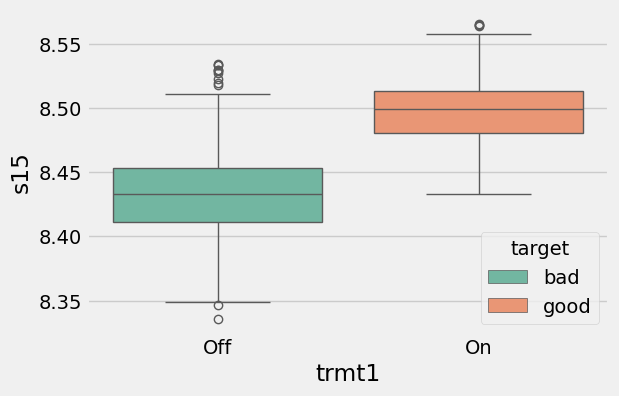

Setting1, target good:0.030000000000000013
Setting1 Off, target bad:0.030000000000000002
p-value: 1.0013225823574612e-48



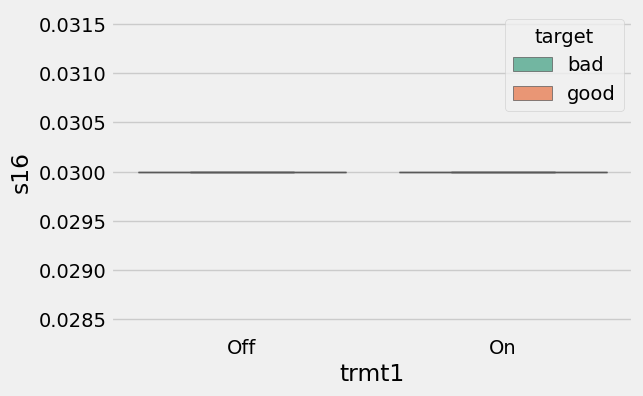

Setting1, target good:395.37654320987656
Setting1 Off, target bad:392.85709010339735
p-value: 1.118770194172644e-189



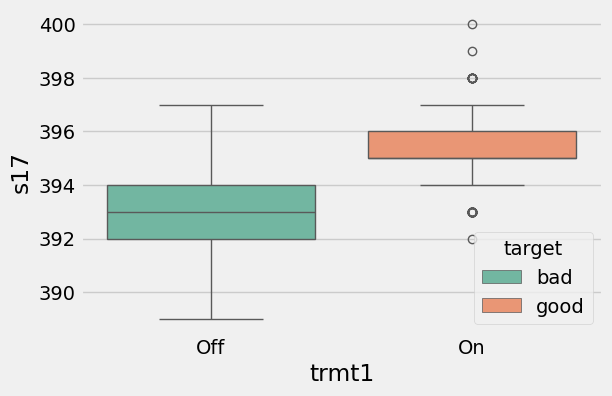

Setting1, target good:2388.0
Setting1 Off, target bad:2388.0
p-value: nan



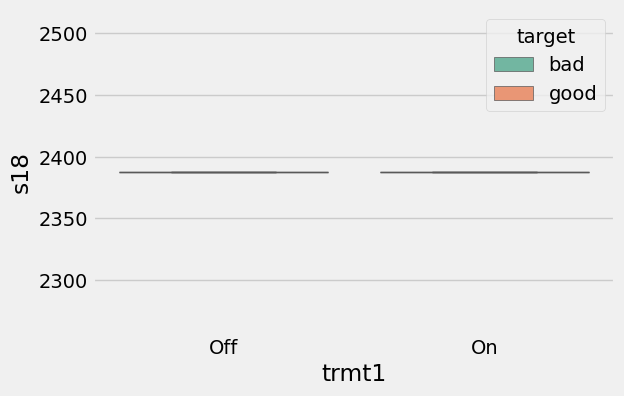

Setting1, target good:100.0
Setting1 Off, target bad:100.0
p-value: nan



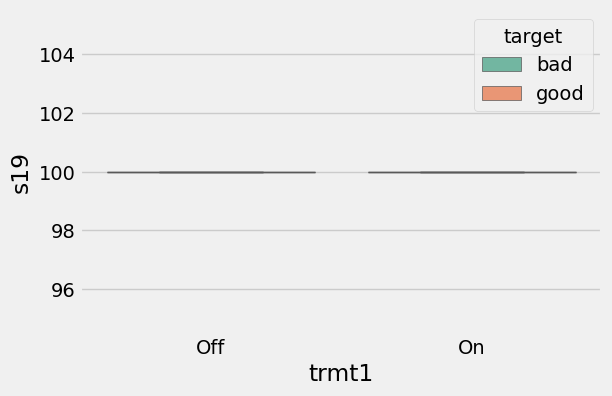

Setting1, target good:38.55769547325103
Setting1 Off, target bad:38.858581979320526
p-value: 1.2432941336068032e-228



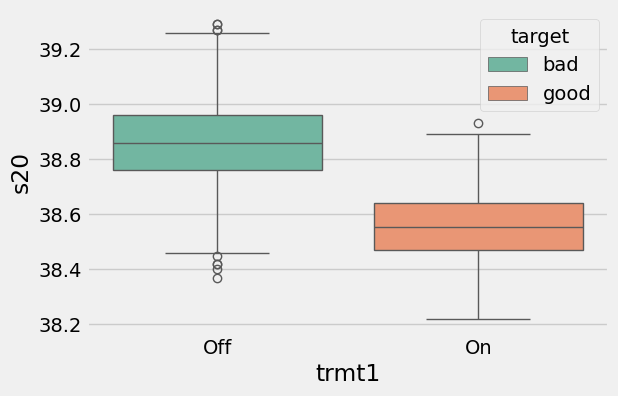

Setting1, target good:23.12861748971193
Setting1 Off, target bad:23.317122525849335
p-value: 1.5024313117430944e-237



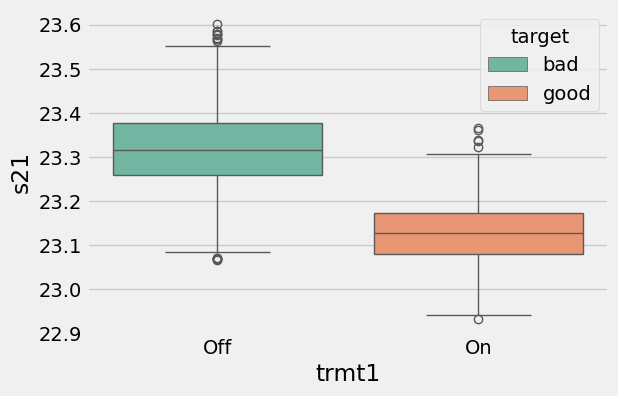

In [ ]:
from scipy.stats import chi2_contingency

col = confounding_col

for i in col:
    group1 = ex_data.query("(trmt1=='On' & target=='good')")[i]
    group2 = ex_data.query("(trmt1=='Off' & target=='bad')")[i]


    print(f'trmt, target good:{group1.mean()}')
    print(f'trmt Off, target bad:{group2.mean()}')
    t_stat, p_value = ttest_ind(group1, group2, equal_var=False)  # 등분산 가정하지 않음
    print(f"p-value: {p_value}\n")

    plt.figure(figsize=(6, 4))
    sns.boxplot(data=ex_data.query("(trmt1=='On' & target=='good') |(trmt1=='Off' & target=='bad')"),
                    x='trmt1', y=i,
                    hue='target',
                    palette='Set2')
    plt.xlabel('trmt1')
    plt.ylabel(i)
    plt.show()

# 3. 모형탐색

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from causalml.inference.meta import BaseTClassifier
import numpy as np
from scipy.stats import randint, uniform

# 하이퍼파라미터 그리드 정의
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 15),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', uniform(0.3, 0.7)]
}

# 대조군과 처치군 각각에 대해 별도 learner 정의
control_learner = RandomForestClassifier(random_state=24)
treatment_learner = RandomForestClassifier(random_state=24)

# 대조군(T=0) 모델 튜닝
grid_search_control = RandomizedSearchCV(
    estimator=control_learner,
    param_distributions=param_dist,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_control.fit(X=train[train[T] == 0][X], y=train[train[T] == 0][y])
best_control_learner = grid_search_control.best_estimator_

# 처치군(T=1) 모델 튜닝
grid_search_treatment = RandomizedSearchCV(
    estimator=treatment_learner,
    param_distributions=param_dist,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_treatment.fit(X=train[train[T] == 1][X], y=train[train[T] == 1][y])
best_treatment_learner = grid_search_treatment.best_estimator_

# 최적화된 모델로 T-Learner 재구성
t_learner_rf_opt = BaseTClassifier(
    control_learner=best_control_learner,
    treatment_learner=best_treatment_learner,
    control_name=0
)
t_learner_rf_opt.fit(X=train[X], treatment=train[T], y=train[y])

In [ ]:
ate_t_rf = t_learner_rf_opt.estimate_ate(X=test[X], treatment=test[T], y=test[y])
ite_t_rf = t_learner_rf_opt.predict(X=test[X], treatment=test[T])

print(f"T-Classifier (RandomForest) ATE: {ate_t_rf[0].item():.4f} (95% CI: [{ate_t_rf[1].item():.4f}, {ate_t_rf[2].item():.4f}])")

T-Classifier (RandomForest) ATE: 0.0000 (95% CI: [-0.0068, 0.0068])


auuc_score : uplift_tree    0.870764
dtype: float64
qini_score : uplift_tree    0.83994
dtype: float64


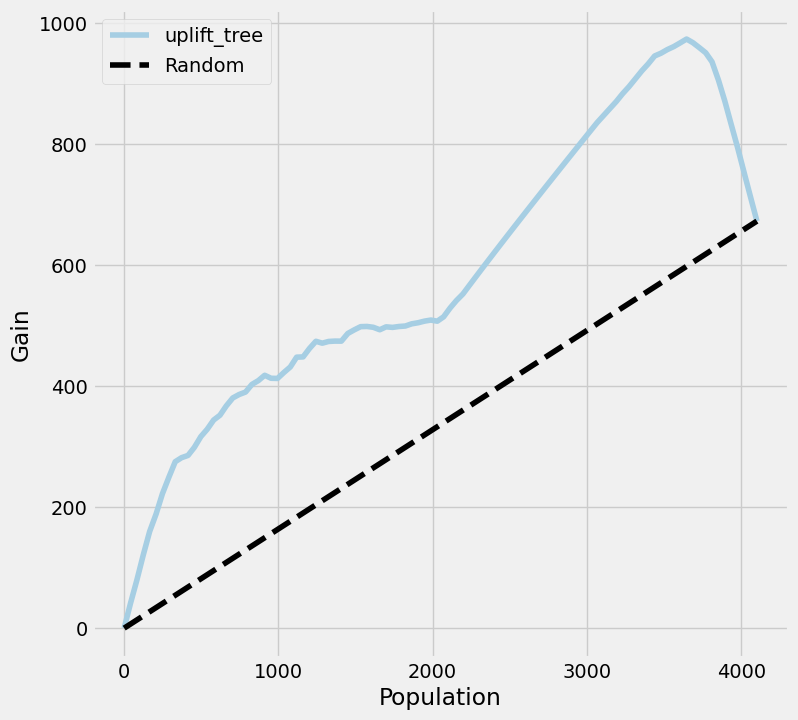

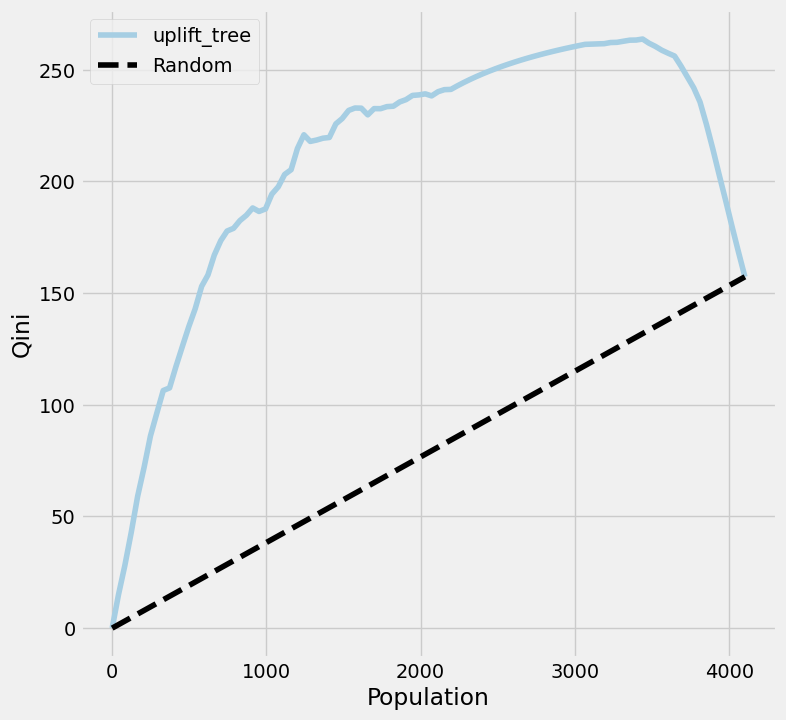

In [ ]:
result = pd.DataFrame(ite_t_rf,
                      columns=['treatment'])
best_treatment = np.where((result < 0).all(axis=1),
                           'c',
                           result.idxmax(axis=1))

actual_is_best = np.where(test[T].replace([0,1],['c','treatment']) == best_treatment, 1, 0)
actual_is_control = np.where(test[T].replace([0,1],['c','treatment']) == 'c', 1, 0)
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result[synthetic]

auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             target = test.loc[synthetic, 'target'].values.astype(int),
                             uplift_tree = synth.max(axis=1)))

auuc_lr = auuc_score(auuc_metrics.drop(columns='treatment'), outcome_col='target', treatment_col='is_treated')
print(f'auuc_score : {auuc_lr}')

plot_gain(auuc_metrics.drop(columns='treatment'), outcome_col='target', treatment_col='is_treated')

qini_lr = qini_score(auuc_metrics.drop(columns='treatment'), outcome_col='target', treatment_col='is_treated')
print(f'qini_score : {qini_lr}')
plot_qini(auuc_metrics.drop(columns='treatment'), outcome_col='target', treatment_col='is_treated')